### Create the detex tooth detection data set ###

We will crop the large panoramic x-rays down to smaller images containing the teeth in each quadrant.
We will then use the smaller high-resolution images as inputs to the detection model.

In [76]:
import os
import numpy as np
import pandas as pd
import glob
import json
import copy
import random
from pathlib import Path
import logging
import itertools
from PIL import Image

from matplotlib import pyplot as plt
from matplotlib import patches

logger = logging.getLogger(name=__name__)

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import detection as dt
from detection.dentexdata import DentexData
from detection.fileutils import FileOP
from detection.imageproc import ImageData, xywh2xyxy, xyxy2xywh, clipxywh

print(f'Project module version: {dt.__version__}')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project module version: 0.0.1.post1.dev16+g367a5b6


### Define data locations for this notebook ###

In [2]:
# Data directory
data_root = os.path.join(os.environ.get('HOME'), 'data')
data_dir = os.path.join(data_root, 'dentex_detection')
model_dir = os.path.join(data_dir, 'model')

Path(data_dir).mkdir(exist_ok=True, parents=True)
Path(model_dir).mkdir(exist_ok=True, parents=True)

# This is where the xrays are in the archive, so should be left as-is
image_dir = os.path.join(data_dir, 'quadrant_enumeration', 'xrays')
print(f'image_dir: {image_dir}')

image_dir: /app/data/dentex_detection/quadrant_enumeration/xrays


### Make sure that the data is available ###

In [3]:
# Check the images on disk
file_list = glob.glob(os.path.join(image_dir, '*.png'))
expected_n_images = 634
if not len(file_list) == expected_n_images:
    print(f'WARNING: expected number of images ({expected_n_images}) does not match the number of images on disk.')
    print(f'Delete files and start over.')
else:
    print(f'Found {len(file_list)} images.')

Found 634 images.


### Functions ###

In [34]:
# Create a function to show an image with bounding boxes
def show_image_with_boxes(image, box_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    color = plt.cm.rainbow(np.linspace(0, 1, len(box_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for b, box in enumerate(box_list):
        if edgecolor is None:
            boxcolor = color_list[b]
        else:
            boxcolor = edgecolor
        anchor = (box[0], box[1])
        width = box[2]
        height = box[3]
        #anchor, width, height = rectangle(box)
        rect = patches.Rectangle(xy=anchor, 
                                 width=width, 
                                 height=height, 
                                 linewidth=1.5, 
                                 edgecolor=boxcolor, 
                                 facecolor='none', 
                                 alpha=alpha)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=anchor[0]+width, y=anchor[1], s=label_list[b], color=boxcolor)
    ax.set(xticks=[], yticks=[])
    return ax

# Create a function to show an image with segmentations
def show_image_with_segmentations(image, segmentation_list, label_list=None, alpha=0.7, edgecolor=None, ax=None):
    # Convert list of segmentations to arrays (N, 2)
    segmentation_edges_list = [segmentation_edges(seg[0]) for seg in segmentation_list]
    color = plt.cm.rainbow(np.linspace(0, 1, len(segmentation_list)))
    color_list = [color[c] for c in range(len(color))]
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(image)
    for s, seg in enumerate(segmentation_edges_list):
        if edgecolor is None:
            seg_color = color_list[s]
        else:
            seg_color = edgecolor
        anchor = (min(seg[:, 0]), min(seg[:, 1]))
        contour = patches.Polygon(xy=seg, 
                                  linewidth=1.5, 
                                  edgecolor=seg_color,
                                  facecolor=seg_color, 
                                  alpha=0.5)
        ax.add_patch(contour)
        if label_list is not None:
            ax.text(x=anchor[0], y=anchor[1], s=label_list[s], color=seg_color)
    ax.set(xticks=[], yticks=[])
    return ax

# Flatten list of lists
def flatten(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))

# Create position number mapping
# FDI - ADA position numbering
def fdi_ada_mapping():
    fdi, ada = [], []
    for q in range(1, 5):
        for p in range(1, 9):
            fdi.append(int(str(q) + str(p)))
        if q in [1, 3]:
            for a in range(8*q, 8*(q-1), -1):
                ada.append(a)
        else:
            for a in range(8*(q-1), 8*q, 1):
                ada.append(a + 1)
    return fdi, ada

# Create a (quadrant) bounding box that contains a list of bounding boxes
def compass_box(bbox_list_xywh: list, offset:int) -> list:
    assert isinstance(bbox_list_xywh, list)
    bbox_list_xyxy = [xywh2xyxy(bbox) for bbox in bbox_list_xywh]
    bbox_list_x = flatten([[bbox[0], bbox[2]] for bbox in bbox_list_xyxy])
    bbox_list_y = flatten([[bbox[1], bbox[3]] for bbox in bbox_list_xyxy])
    quadrant_bbox_xywh = xyxy2xywh([min(bbox_list_x)-offset, 
                                    min(bbox_list_y)-offset, 
                                    max(bbox_list_x)+offset, 
                                    max(bbox_list_y)+offset])
    return quadrant_bbox_xywh

# Create a function to build (x, y) tuples from segmentation lists
def segmentation_edges(segmentation: list) -> np.ndarray:
    output = None
    try:
        assert isinstance(segmentation, list)
        assert isinstance(segmentation[0], (int, np.int64))
        assert len(segmentation) % 2 == 0
    except AssertionError as e:
        logger.error('segmentation must be a flat even-lenth list of integer values')
    else:
        seg_x = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 0]
        seg_y = [segmentation[i] for i in range(len(segmentation)) if i % 2 == 1]
        output = np.array(list(zip(seg_x, seg_y)))
    return output

# Category mapping
fdi, ada = fdi_ada_mapping()
fdi2ada = dict(zip(fdi, ada))
ada2fdi = {v: k for k, v in fdi2ada.items()}

### Load the annotations into a data frame ###

In [84]:
annotations_file_name = 'train_quadrant_enumeration.json'
annotations_file = os.path.join(data_dir, 
                                'quadrant_enumeration', 
                                annotations_file_name)
dtx = DentexData(data_dir=data_dir)
annotations = dtx.load_annotations(annotations_file)

# Convert the annotations into a data frame
df = dtx.annotations_to_df()

# The categories are the quadrants and tooth positions
df = df.rename(columns={'category_id_1_name': 'quadrant',
                        'category_id_2_name': 'pos'})

display(df.head(2))

print(f'Number of panoramic x-rays in data set:   {len(df['file_name'].unique())}')
print(f'Total number of annotations in data set:{df.shape[0]}')

,iscrowd,image_id,bbox,segmentation,id,area,category_id_1,category_id_2,height,width,file_name,quadrant,pos
0,0,1,"[1283.3333333333333, 459.25925925925924, 100.0...","[[1366, 459, 1383, 662, 1380, 716, 1295, 721, ...",1,22904,0,0,1316,2710,train_283.png,1,1
1,0,1,"[1200.0, 460.18518518518516, 90.74074074074065...","[[1290, 463, 1290, 619, 1276, 719, 1224, 725, ...",2,18597,0,1,1316,2710,train_283.png,1,2


Number of panoramic x-rays in data set:   634
Total number of annotations in data set:18095


In [36]:
# Let's draw an x-ray image with the bounding boxes in one quadrant
image_idx = 223
quadrant = 1

file_name = sorted(list(df['file_name'].unique()))[image_idx]
print(file_name)

# Load the image
file = os.path.join(image_dir, file_name)
im = ImageData().load_image(file)
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])

df_file = df.loc[(df['file_name'] == file_name) & (df['quadrant'] == quadrant)]

# Get the bounding boxes
box_list_xywh = df_file['bbox'].tolist()
box_list_xywh = [clipxywh(box, xlim=xlim, ylim=ylim, decimals=0) for box in box_list_xywh]

# Segmentations
segmentation_list = df_file['segmentation'].tolist()

# Tooth positions
pos_list = df_file['pos'].tolist()
pos_list_fdi = [int(f'{quadrant}{pos}') for pos in pos_list]

# Create the quadrant bounding box
# Make the quadrant bounding box just a little bit bigger
quadrant_box_xywh = compass_box(bbox_list_xywh=box_list_xywh, offset=10)

train_3.png


In [37]:
# Conversions of segmentations
segmentation_list = df_file['segmentation'].tolist()
segmentation_edges_list = [segmentation_edges(seg[0]) for seg in segmentation_list]
segmentation_list_flattened = [[flatten(seg)] for seg in segmentation_edges_list]

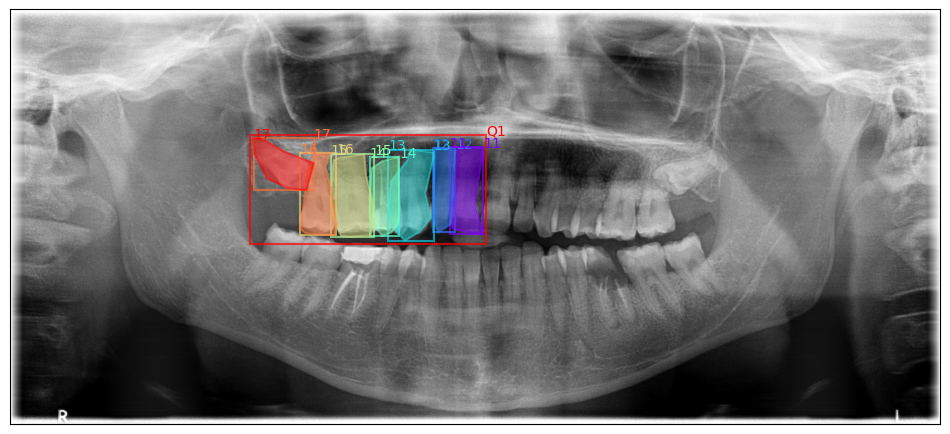

In [38]:
# Show this image with the bounding boxes and segmentations
bbox_list = copy.deepcopy(box_list_xywh)
bbox_list.append(quadrant_box_xywh)
label_list = copy.deepcopy(pos_list_fdi)
label_list.append(f'Q{quadrant}')
fig, ax = plt.subplots(figsize=(12,6))
ax = show_image_with_boxes(image=im, box_list=bbox_list, label_list=label_list, ax=ax)
ax = show_image_with_segmentations(image=im, segmentation_list=segmentation_list, label_list=label_list, ax=ax)
plt.show()

### Create quadrant data set ###

In [99]:
# Define an offset for the quadrant bounding box
quadrant_offset = 10

# Keep only a few columns from the original data frame
keep_cols = ['file_name', 'quadrant', 'pos']

# Output directory
output_dir = os.path.join(data_dir, 'quadrants')
Path(output_dir).mkdir(exist_ok=True, parents=True)

# Output_directory for the example images
overlay_output_dir = os.path.join(data_dir, 'quadrants_overlay')
Path(overlay_output_dir).mkdir(exist_ok=True, parents=True)

# LOOP OVER THE FILES
file_name_list = sorted(list(df['file_name'].unique()))
print(len(file_name_list))

# Save the original data frame
df_annotations_file_name = f'{os.path.splitext(annotations_file_name)[0]}.parquet'
df_annotations_file = os.path.join(output_dir, df_annotations_file_name)
df.to_parquet(df_annotations_file)

# Shuffle, just for creating some example overlay images
# random.shuffle(file_name_list)

634


In [101]:
# LOOP OVER THE FILES
cropped_df_list = []
for f, file_name in enumerate(file_name_list):

    if (f+1) % 100 == 0:
        print(f'File {f+1}/{len(file_name_list)}') 
    
    # Load the image
    file = os.path.join(image_dir, file_name)
    im = ImageData().load_image(file)
    xlim, ylim = (0, im.shape[1]), (0, im.shape[0])
    
    # LOOP OVER THE QUADRANTS FOR EACH FILE
    file_quadrant_list = sorted(list(df.loc[df['file_name'] == file_name, 'quadrant'].unique()))
    for quadrant in file_quadrant_list:
        
        # Crate a new image name
        quadrant_file_name = f'{os.path.splitext(file_name)[0]}_{quadrant}.png'
        quadrant_file = os.path.join(output_dir, quadrant_file_name)
        
        # Get the bounding boxes
        file_quadrant_df = df.loc[(df['file_name'] == file_name) & (df['quadrant'] == quadrant)]
        bbox_list_xywh = file_quadrant_df['bbox'].tolist()
        pos_list = file_quadrant_df['pos'].tolist()
        pos_list_fdi = [int(f'{quadrant}{pos}') for pos in pos_list]
        pos_list_ada = [fdi2ada.get(fdi) for fdi in pos_list_fdi]
        quadrant_bbox_xywh = compass_box(bbox_list_xywh=bbox_list_xywh, offset=quadrant_offset)
        qb = xywh2xyxy(clipxywh(xywh=quadrant_bbox_xywh, xlim=xlim, ylim=ylim, decimals=0))
        
        # Get the segmentations
        segmentation_list = file_quadrant_df['segmentation'].tolist()
        segmentation_edges_list = [segmentation_edges(seg[0]) for seg in segmentation_list]
        
        # Crop the image
        im_cropped = im[qb[1]:qb[3], qb[0]:qb[2],]
        pil_im = Image.fromarray(im_cropped, mode='RGB')
        pil_im.save(quadrant_file)
        xlim_cropped, ylim_cropped = (0, im_cropped.shape[1]), (0, im_cropped.shape[0])
        
        # Create the new bounding boxes for the cropped image
        bbox_list_xywh_cropped = [[box[0]-qb[0], box[1]-qb[1], box[2], box[3]] for box in bbox_list_xywh]
        bbox_list_xywh_cropped = [clipxywh(box, xlim=xlim_cropped, ylim=ylim_cropped, decimals=0) for box in bbox_list_xywh_cropped]
        
        # Create the new segmentation polygons for the cropped image
        segmentations_edges_cropped = [np.subtract(seg, [qb[0], qb[1]]) for seg in segmentation_edges_list]
        segmentation_cropped = [[flatten(seg)] for seg in segmentations_edges_cropped]
        
        # Create a new data frame for this image
        df_quadrant = file_quadrant_df[keep_cols].\
                        reset_index(drop=True).\
                        assign(file_name=quadrant_file_name).\
                        assign(bbox=bbox_list_xywh_cropped).\
                        assign(segmentation=segmentation_cropped)
        
        cropped_df_list.append(df_quadrant)

# Concatenate the annotations data frames
cropped_df = pd.concat(cropped_df_list, axis=0, ignore_index=True)

# Save the data frame with the new annotations
df_cropped_annotations_file_name = f'{os.path.splitext(annotations_file_name)[0]}_cropped.parquet'
df_cropped_annotations_file = os.path.join(output_dir, df_cropped_annotations_file_name)
cropped_df.to_parquet(df_cropped_annotations_file)

File 100/634
File 200/634
File 300/634
File 400/634
File 500/634
File 600/634


In [102]:
display(cropped_df.head(2))

,file_name,quadrant,pos,bbox,segmentation
0,train_0_1.png,1,1,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]"
1,train_0_1.png,1,2,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,..."


In [104]:
print(f'Total number of cropped images: {len(cropped_df['file_name'].unique())}')
print(f'Total number of annotations:    {cropped_df.shape[0]}')

Total number of cropped images: 2531
Total number of annotations:    18095


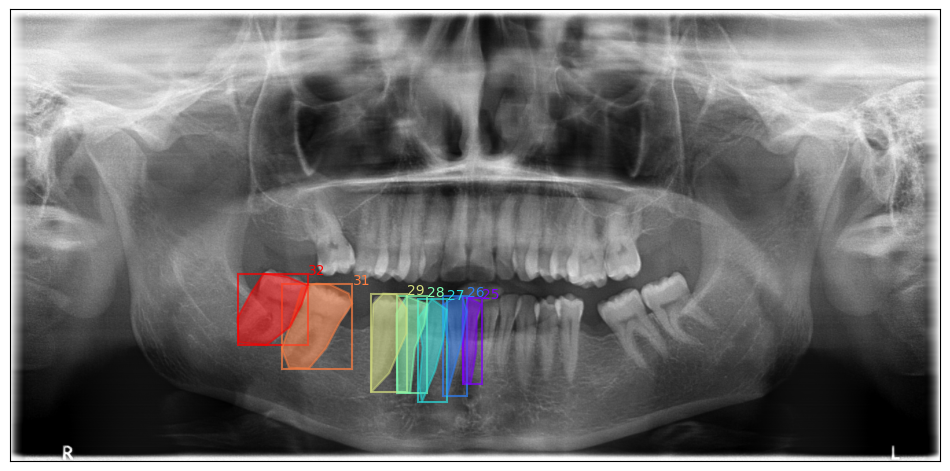

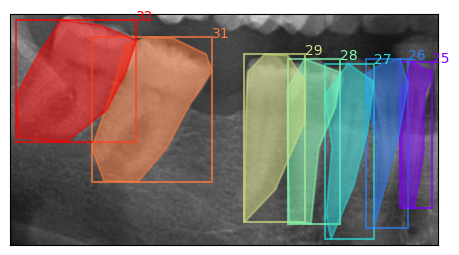

In [106]:
# Show the original panoramic image with bounding boxes and segmentations
fig, ax = plt.subplots(figsize=(12,6))
ax = show_image_with_boxes(image=im, 
                           box_list=bbox_list_xywh, 
                           label_list=pos_list_ada, 
                           ax=ax)
ax = show_image_with_segmentations(image=im,
                                   segmentation_list=segmentation_list,
                                   label_list=None,
                                   alpha=0.3,
                                   ax=ax)

overlay_file_name = f'{os.path.splitext(file_name)[0]}_{quadrant}_full_boxes.png'
overlay_file = os.path.join(overlay_output_dir, overlay_file_name)
# plt.savefig(overlay_file, bbox_inches='tight')
plt.show()

# Show a cropped image with bounding boxes and segmentations
fig, ax = plt.subplots(figsize=(10, 3))
ax = show_image_with_boxes(image=im_cropped, 
                           box_list=bbox_list_xywh_cropped, 
                           label_list=pos_list_ada, 
                           ax=ax)
ax = show_image_with_segmentations(image=im_cropped,
                                   segmentation_list=segmentation_cropped,
                                   label_list=None,
                                   alpha=0.3,
                                   ax=ax)

overlay_file_name = f'{os.path.splitext(file_name)[0]}_{quadrant}_cropped_boxes.png'
overlay_file = os.path.join(overlay_output_dir, overlay_file_name)
# plt.savefig(overlay_file, bbox_inches='tight')
plt.show()